# CNN 구현 연습

## Import

In [2]:
import os
import struct
import tensorflow as tf

In [7]:
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(
                             len(labels), 784)
        images = ((images / 255) - .5) * 2
        
    return images, labels

In [12]:
path = "./mnist/"
X_data, y_data = load_mnist(path, kind='train')
X_test, y_test = load_mnist(path, kind='t10k')

In [13]:
X_train, y_train = X_data[:50000, :], y_data[:50000]
X_valid, y_valid = X_data[50000:, :], y_data[50000:]

In [14]:
print('train set:', X_data.shape)
print('valid set:', X_valid.shape)
print('test set:', X_test.shape)

train set: (60000, 784)
valid set: (10000, 784)
test set: (10000, 784)


## Preprocessing

훈련 성능을 높이고 최적값에 잘 수렴하기 위해 데이터를 정규화(평균을 원점에 맞추고 표준 편차로 나누기)를 할 필요가 있습니다.

In [19]:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = (X_valid - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

현재 이미지는 2차원 배열의 형태를 하고 있습니다. CNN에 데이터를 주입하기 위해서는 784개의 원소로 이루어진 행을 원본 이미지의 차원과 동일한 28 X 28 X 1의 크기로 바꾸어야 합니다. Numpy의 reshape 메서드를 사용하여 차원을 변경합니다. 샘플의 갯수를 의미하는 첫번째 차원은 -1로 두어 나머지 차원에 따라 자동으로 결정될 수 있도록 합니다.

In [27]:
X_train_centered = X_train_centered.reshape((-1, 28, 28, 1))
X_valid_centered = X_valid_centered.reshape((-1, 28, 28, 1))
X_test_centered = X_test_centered.reshape((-1, 28, 28, 1))

그 다음 클래스 레이블을 one-hot encoding 합니다.

In [29]:
from tensorflow.keras.utils import to_categorical

In [30]:
y_train_onehot = to_categorical(y_train)
y_valid_onehot = to_categorical(y_valid)
y_test_onehot = to_categorical(y_test)

In [33]:
print('train set:', X_train_centered.shape, y_train_onehot.shape)
print('valid set:', X_valid_centered.shape, y_valid_onehot.shape)
print('test set:', X_test_centered.shape, y_test_onehot.shape)

train set: (50000, 28, 28, 1) (50000, 10)
valid set: (10000, 28, 28, 1) (10000, 10)
test set: (10000, 28, 28, 1) (10000, 10)


## tf.keras API로 CNN 구성

In [34]:
from tensorflow.keras import layers, models

In [35]:
model = models.Sequential()

In [36]:
model.add(layers.Conv2D(32, (5, 5), padding='valid',
                        activation='relu', input_shape=(28, 28, 1)))

size: 24 X 24 X 32  
parameter: 5 * 5 * 32 + 32 = 832

In [37]:
model.add(layers.MaxPool2D(2, 2))

size: 12 X 12 X 32

In [38]:
model.add(layers.Conv2D(64, (5, 5), padding='valid',
                        activation='relu'))

size: 8 X 8 X 64  
parameter: 5 * 5 * 32 * 64 + 64 = 51,264

In [39]:
model.add(layers.MaxPool2D(2, 2))

size: 4 X 4 X 64

In [40]:
model.add(layers.Flatten())

size: 1,024

In [44]:
model.add(layers.Dense(4*4*64, activation='relu'))

parameter: 1024 * 1024 + 1024 = 1,049,600

In [45]:
model.add(layers.Dropout(0.5))

In [46]:
model.add(layers.Dense(10, activation='softmax'))

parameter: 1024 * 10 + 10 = 10,250

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

모델을 컴파일합시당

In [48]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

모델을 훈련할 때 최선의 가중치를 저장하기 위해 `ModelCheckpoint`, `TensorBoard` 콜백을 추가합니다.

In [49]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath='cnn_checkpoint.h5',
                                 monitor='val_loss',
                                 save_best_only=True),
                 TensorBoard(log_dir="logs/{}".format(time.asctime()))]

자, 자, 자~! 학습을 시작해봅시다.

In [50]:
history = model.fit(X_train_centered, y_train_onehot,
                    batch_size=64, epochs=20,
                    validation_data=(X_valid_centered, y_valid_onehot),
                    callbacks=callback_list)

W0925 21:48:08.352606 4568749504 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 21s 421us/sample - loss: 0.1381 - acc: 0.9568 - val_loss: 0.0468 - val_acc: 0.9855
Epoch 2/20
50000/50000 [==============================] - 20s 409us/sample - loss: 0.0485 - acc: 0.9850 - val_loss: 0.0482 - val_acc: 0.9856
Epoch 3/20
50000/50000 [==============================] - 22s 433us/sample - loss: 0.0355 - acc: 0.9891 - val_loss: 0.0425 - val_acc: 0.9879
Epoch 4/20
50000/50000 [==============================] - 22s 443us/sample - loss: 0.0297 - acc: 0.9901 - val_loss: 0.0352 - val_acc: 0.9895
Epoch 5/20
50000/50000 [==============================] - 20s 397us/sample - loss: 0.0233 - acc: 0.9923 - val_loss: 0.0356 - val_acc: 0.9894
Epoch 6/20
50000/50000 [==============================] - 22s 435us/sample - loss: 0.0206 - acc: 0.9936 - val_loss: 0.0346 - val_acc: 0.9916
Epoch 7/20
50000/50000 [==============================] - 20s 400us/sample - loss: 0.0168 - acc: 0.9948 

## Result

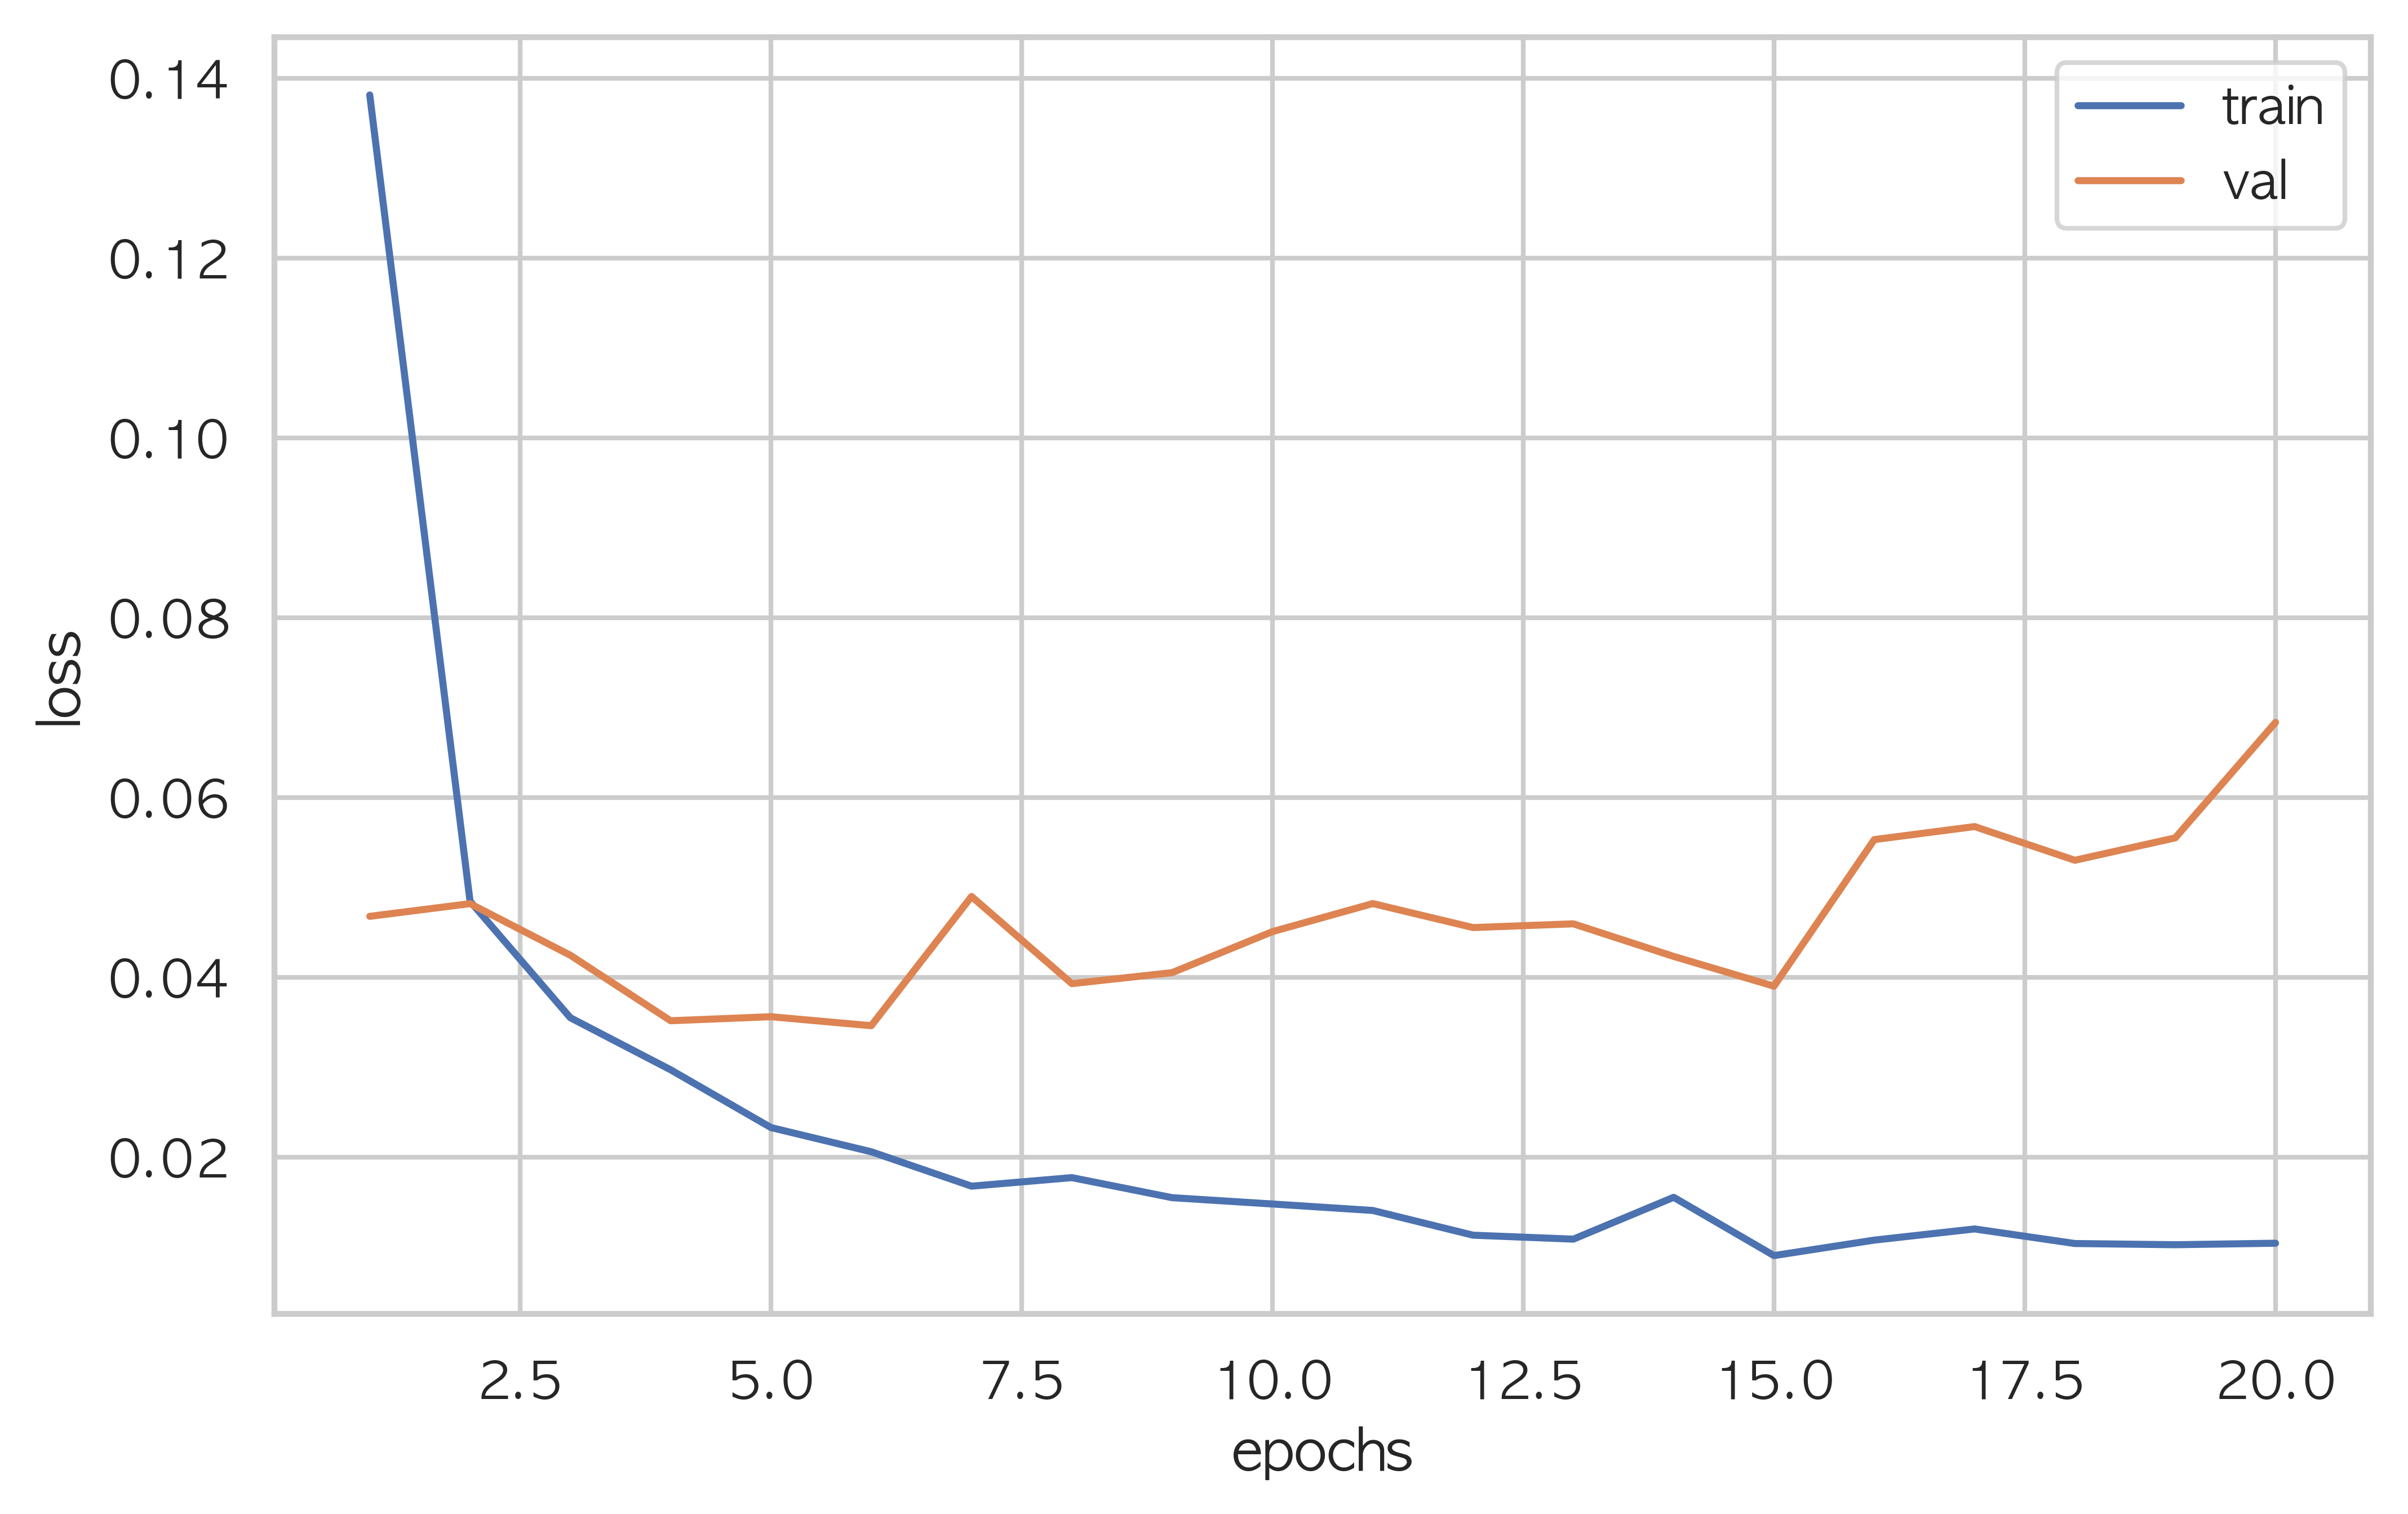

In [56]:
epochs = np.arange(1, 21)
plt.plot(epochs, history.history['loss'], label='train')
plt.plot(epochs, history.history['val_loss'], label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

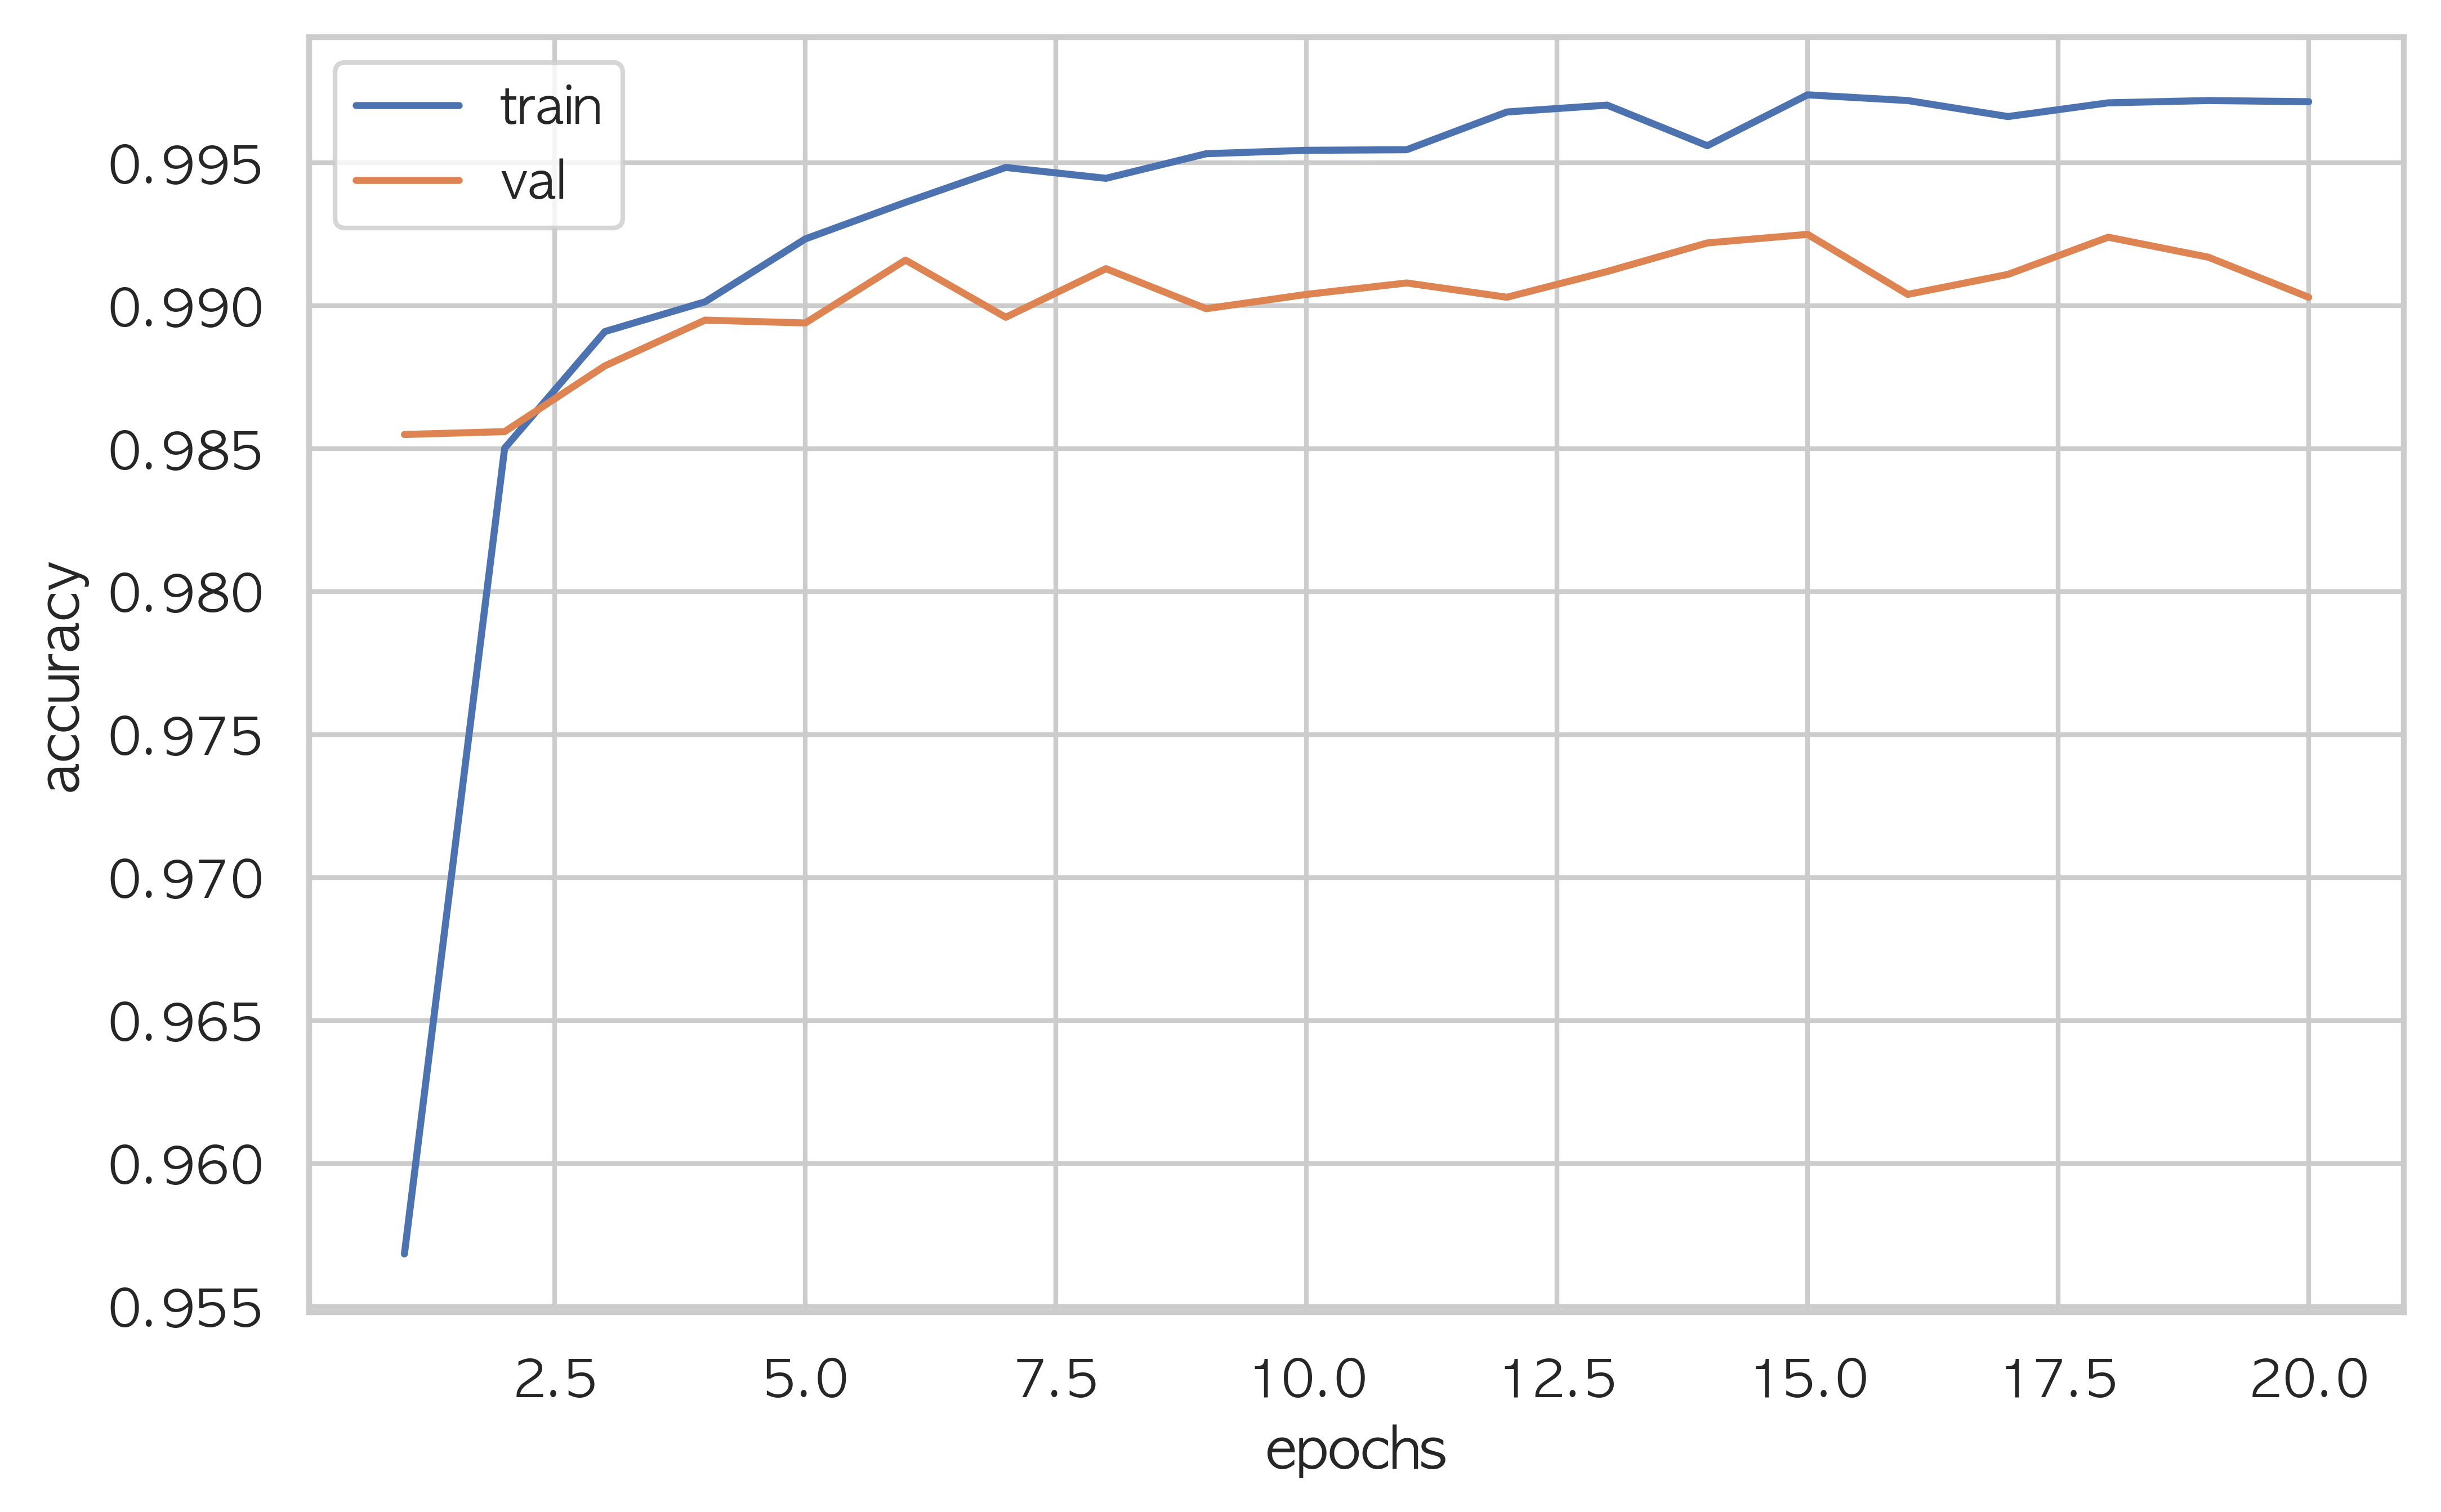

In [55]:
epochs = np.arange(1, 21)
plt.plot(epochs, history.history['acc'], label='train')
plt.plot(epochs, history.history['val_acc'], label='val')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Tensorboard

In [57]:
!tensorboard --logdir logs/

TensorBoard 1.14.0a20190603 at http://Byungwooui-MBP:6006/ (Press CTRL+C to quit)
^C


## Save & Load

In [58]:
model.save('cnn_model.h5')

In [59]:
from tensorflow.keras.models import load_model

In [60]:
restored_model = load_model('cnn_model.h5')
restored_model.load_weights('cnn_checkpoint.h5')

In [61]:
restored_model.evaluate(X_test_centered, y_test_onehot)

10000/10000 [==============================] - 1s 130us/sample - loss: 0.0278 - acc: 0.9916


[0.027814209905543067, 0.9916]

테스트 해봅시다.

In [63]:
np.argmax(restored_model.predict(X_test_centered[:10]), axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [66]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

열 개의 숫자가 어떤 모습인지 직접 이미지를 확인해봅시다.

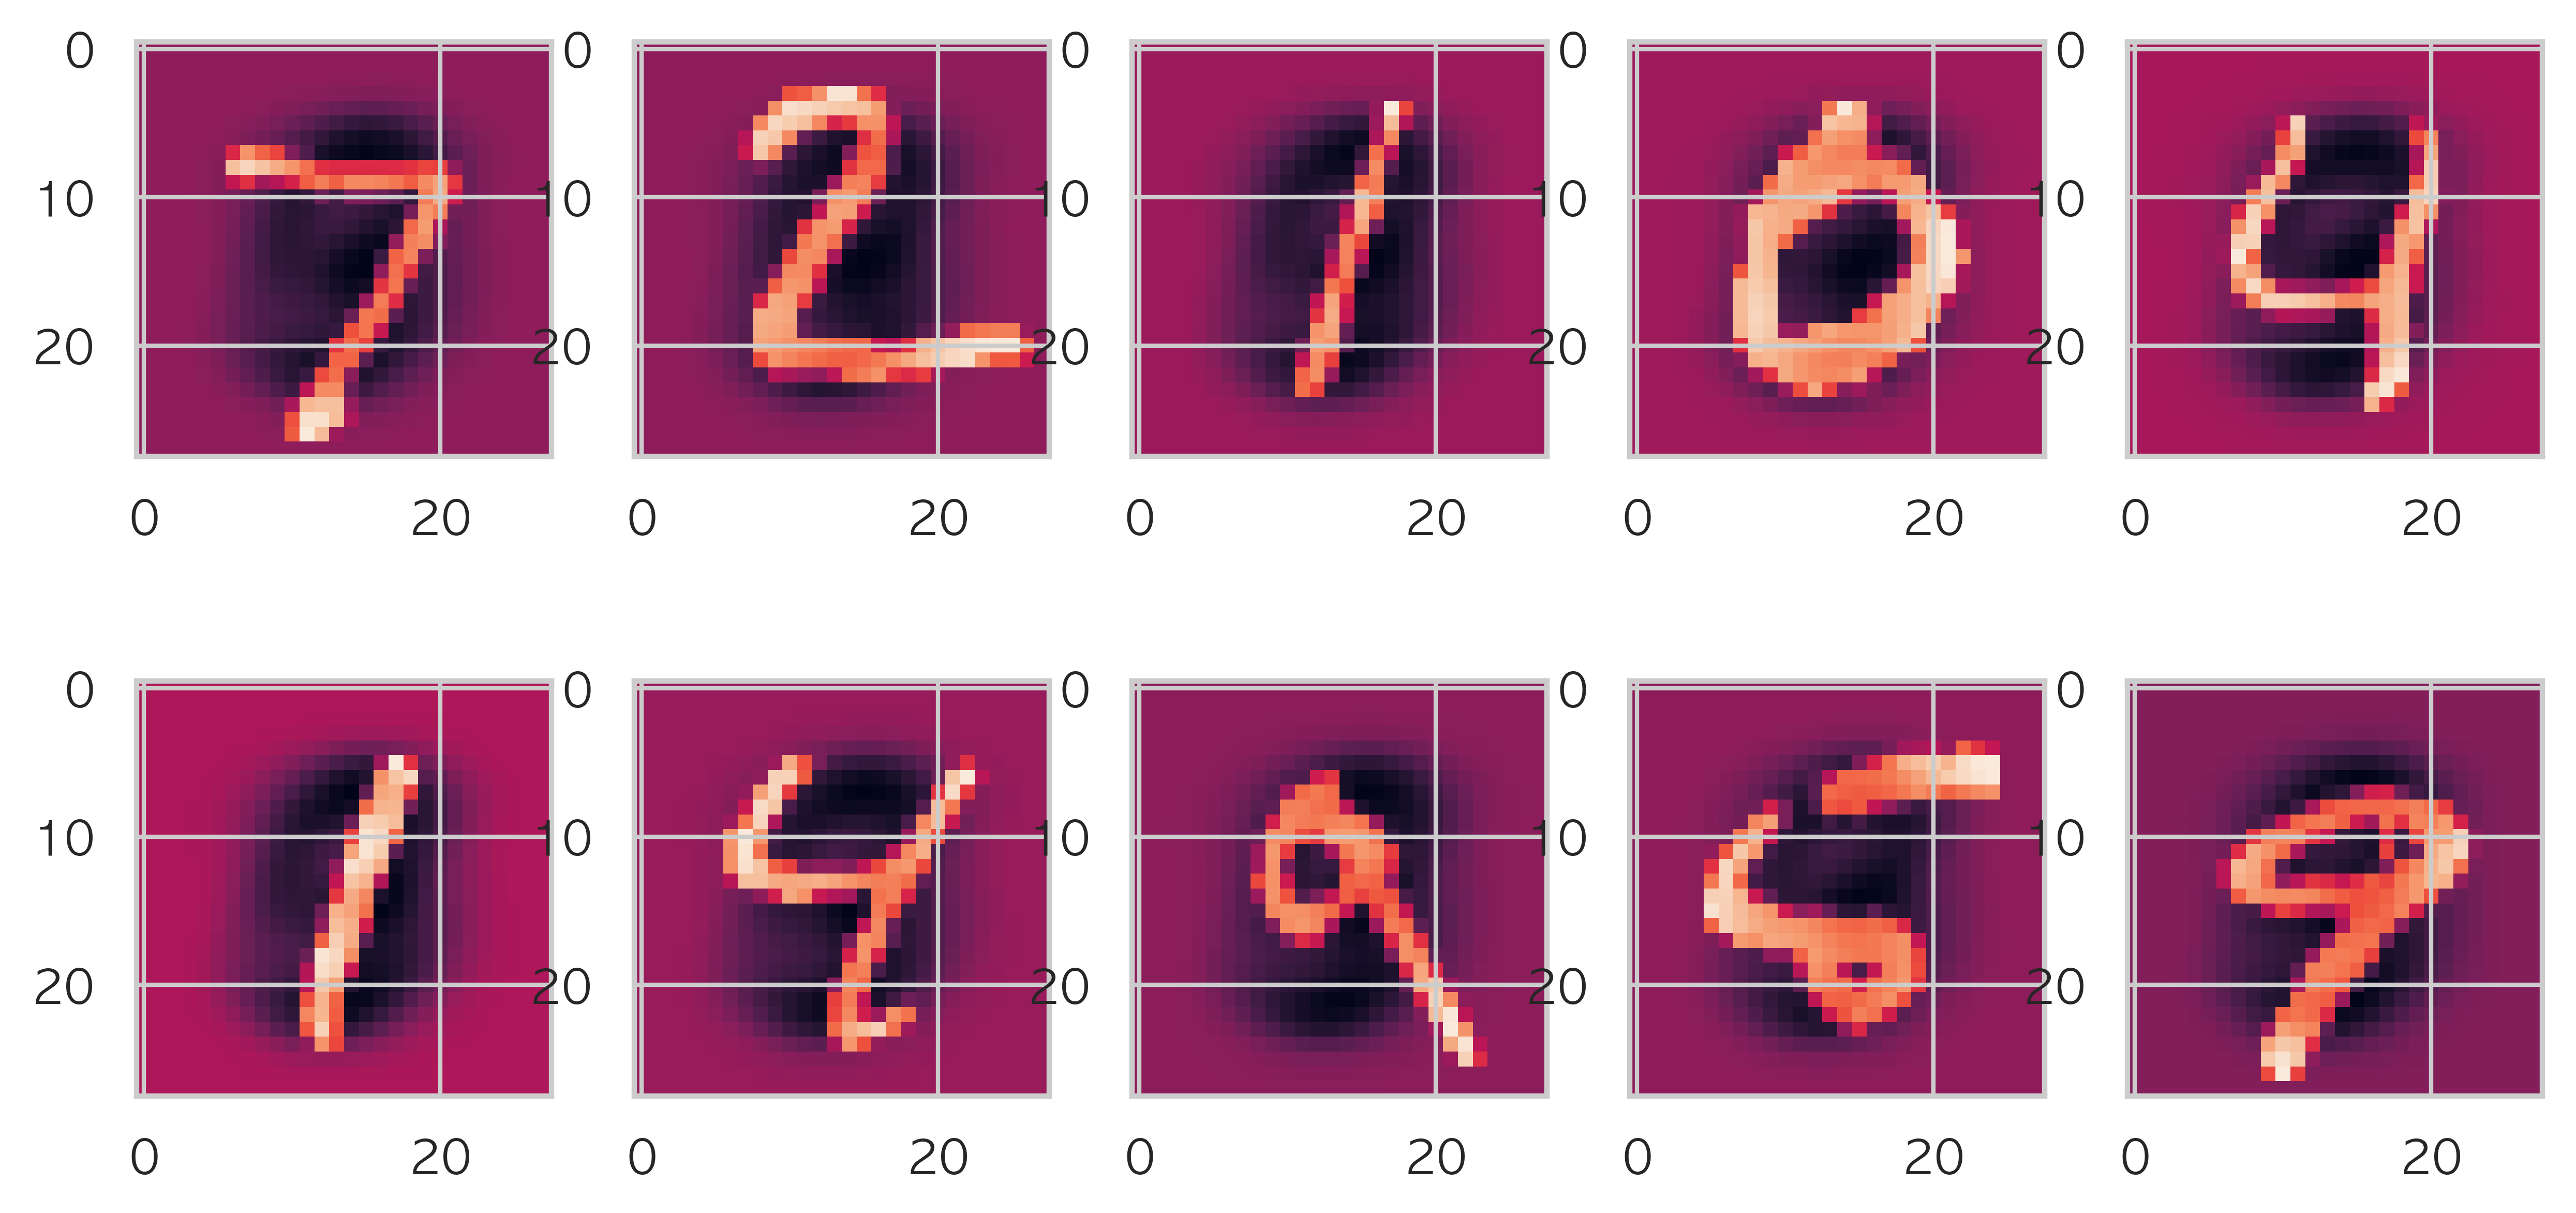

In [68]:
fig = plt.figure(figsize=(10, 5))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(X_test_centered[i].reshape(28, 28))

## 활성화 출력과 필터 시각화

첫번째 합성곱 층의 출력을 이미지로 시각화해 보겠습니다.

In [69]:
first_layer = model.layers[0]
print(first_layer)

first_layer는 Conv2D 객체임을 알 수 있습니다. first_layer의 output 속성을 함수형 API 출력으로 사용하면 첫번째 층의 활성화 출력을 얻을 수 있습니다. Sequential 객체에 layer를 추가하면 자동으로 model 객체 안에 input 속성이 정의됩니다.

In [70]:
print(model.input)

Tensor("conv2d_input:0", shape=(None, 28, 28, 1), dtype=float32)


In [71]:
first_activation = models.Model(inputs=model.input,
                                outputs=first_layer.output)

predict 메서드에서 계산에 사용한 가중치는 앞서 fit 메서드로 훈련한 값입니다. activation 텐서의 크기를 확인해보겠습니다.

In [72]:
activation = first_activation.predict(X_test_centered[:10])
print(activation.shape)

(10, 24, 24, 32)


첫번째 배치 차원은 10이고, 합성곱을 통과하며 높이와 너비가 각각 24 X 24로 줄었습니다. 첫번째 합성곱 layer의 필터가 32개이므로 마지막 차원이 32가 됩니다. 10개의 샘플 중 첫번째 샘플의 feature map 32를 모두 그려봅시당

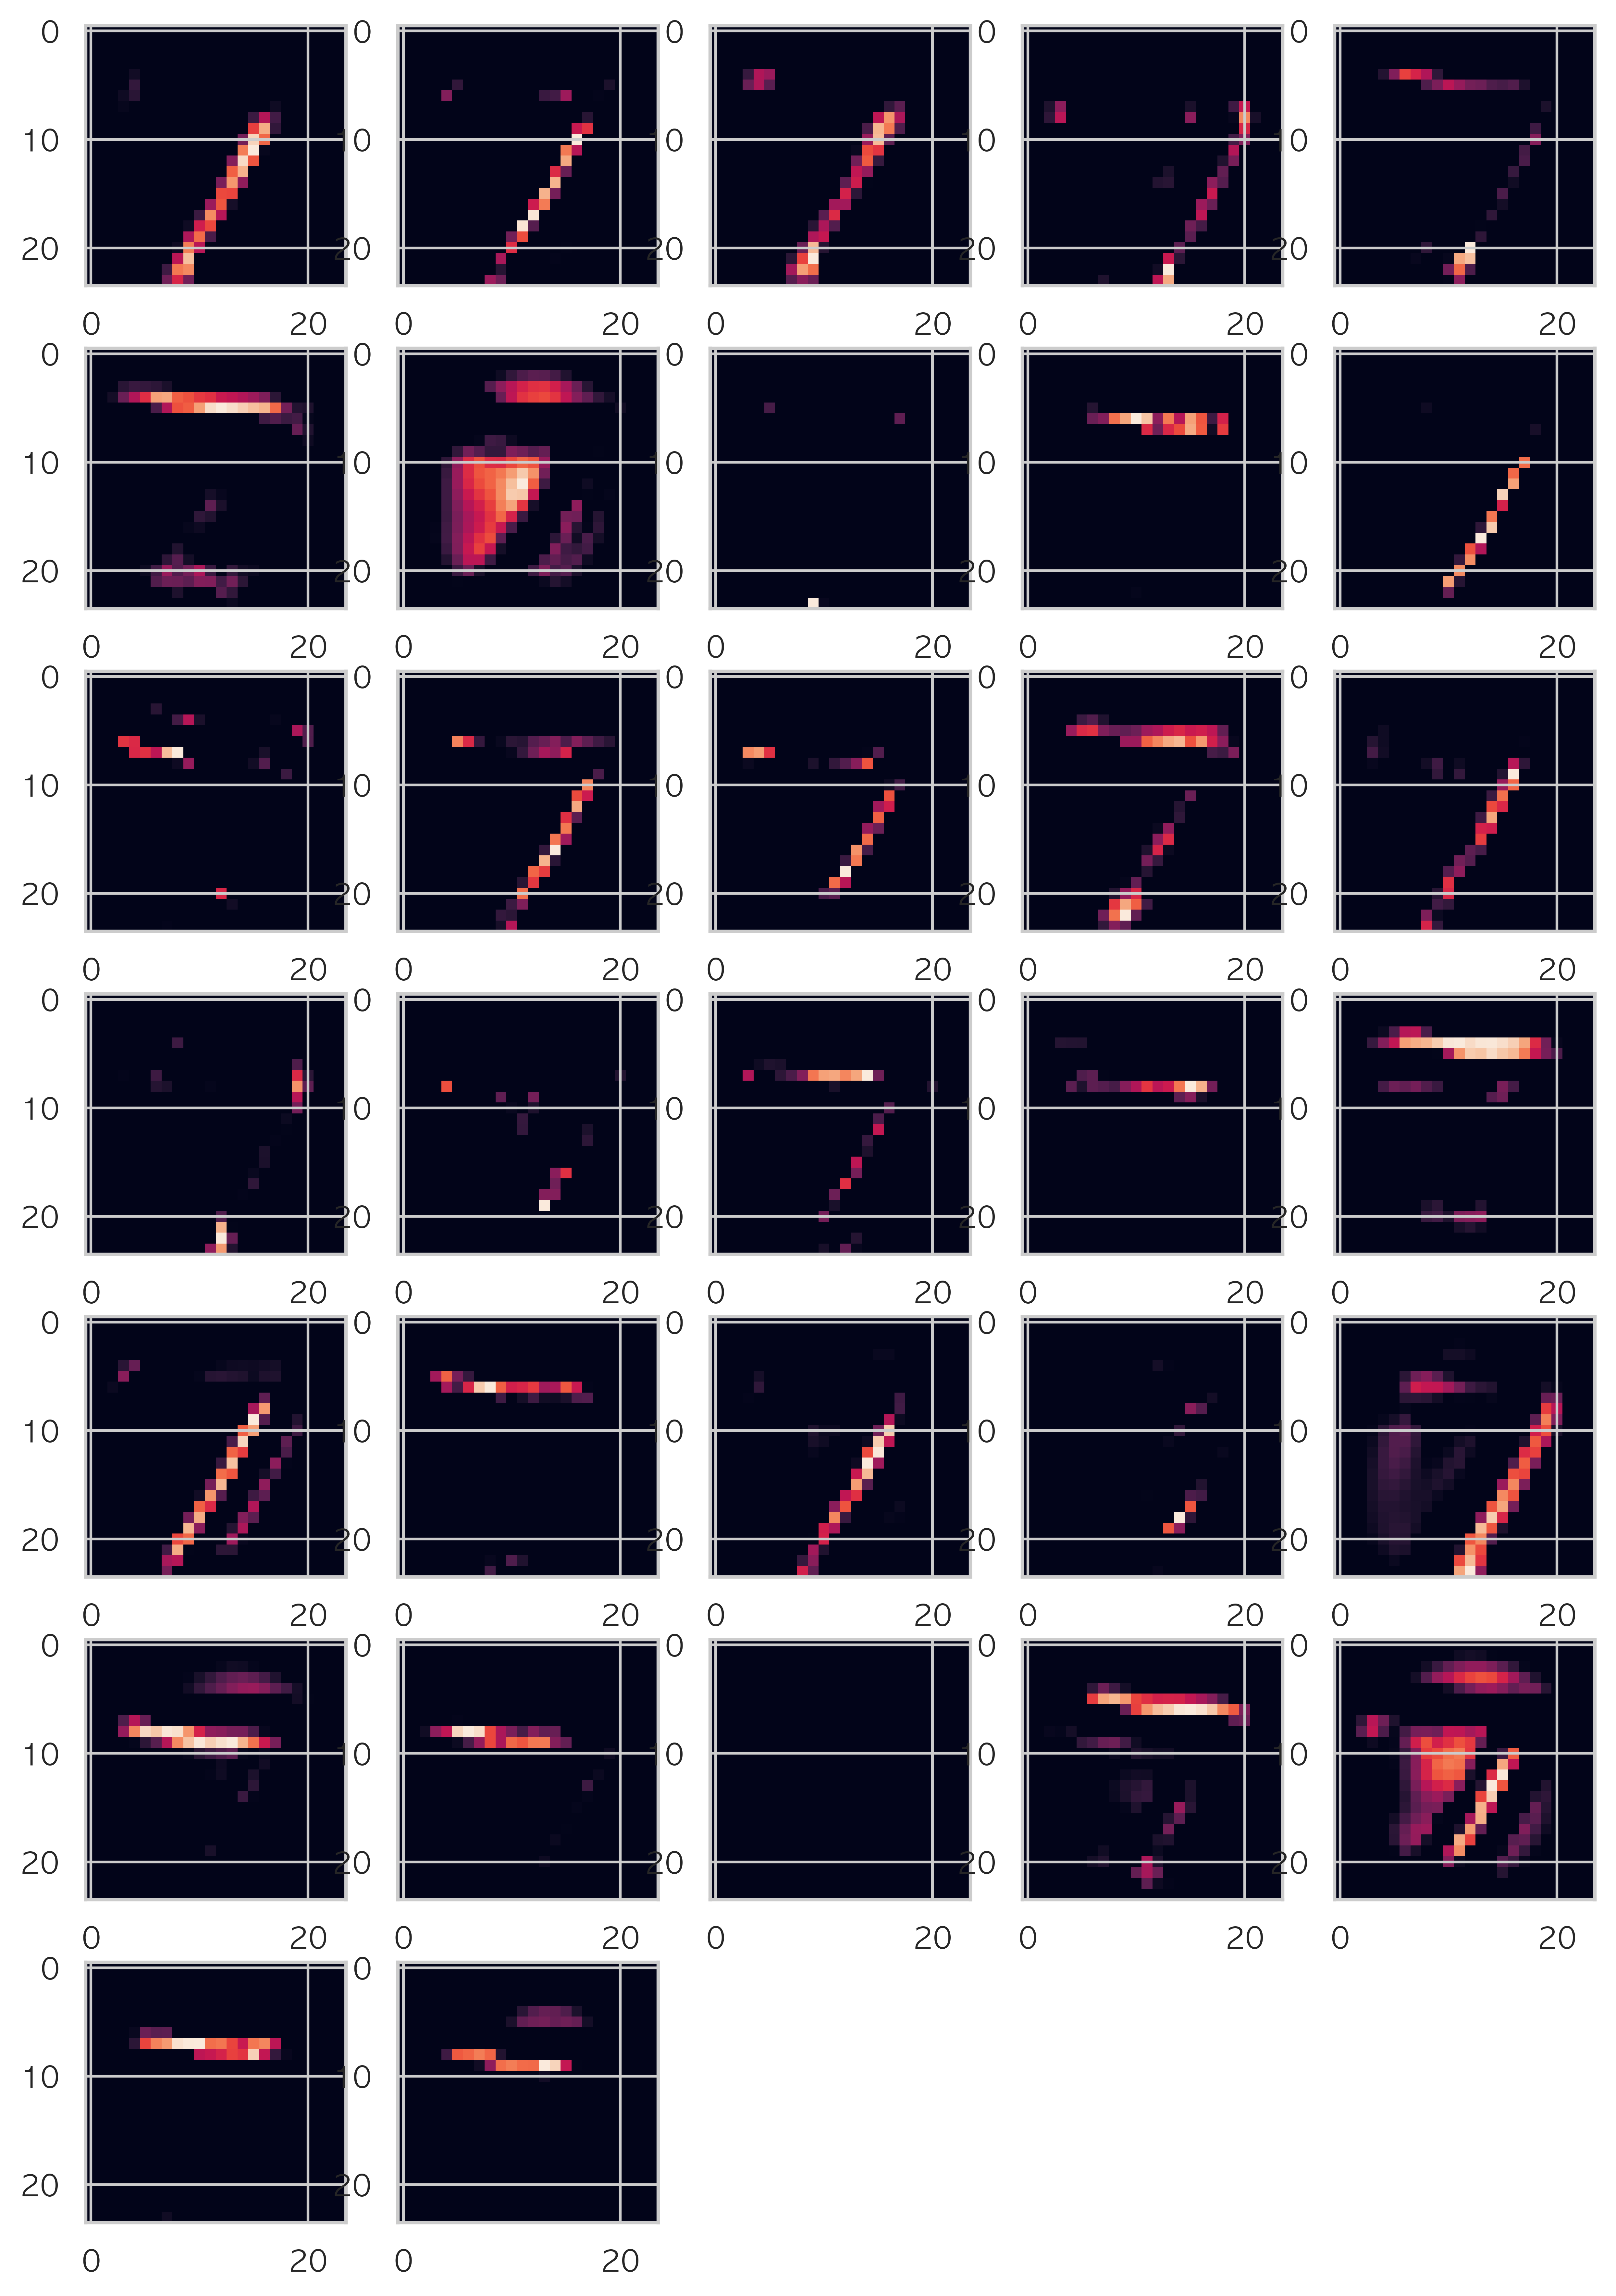

In [73]:
fig = plt.figure(figsize=(10, 15))
for i in range(32):
    fig.add_subplot(7, 5, i+1)
    plt.imshow(activation[0, :, :, i])

숫자 7의 윤곽을 특성으로 잘 추출한 것 같습니다. 이번엔 네 번째 숫자 0의 feature map을 그려보도록 하겠습니다.

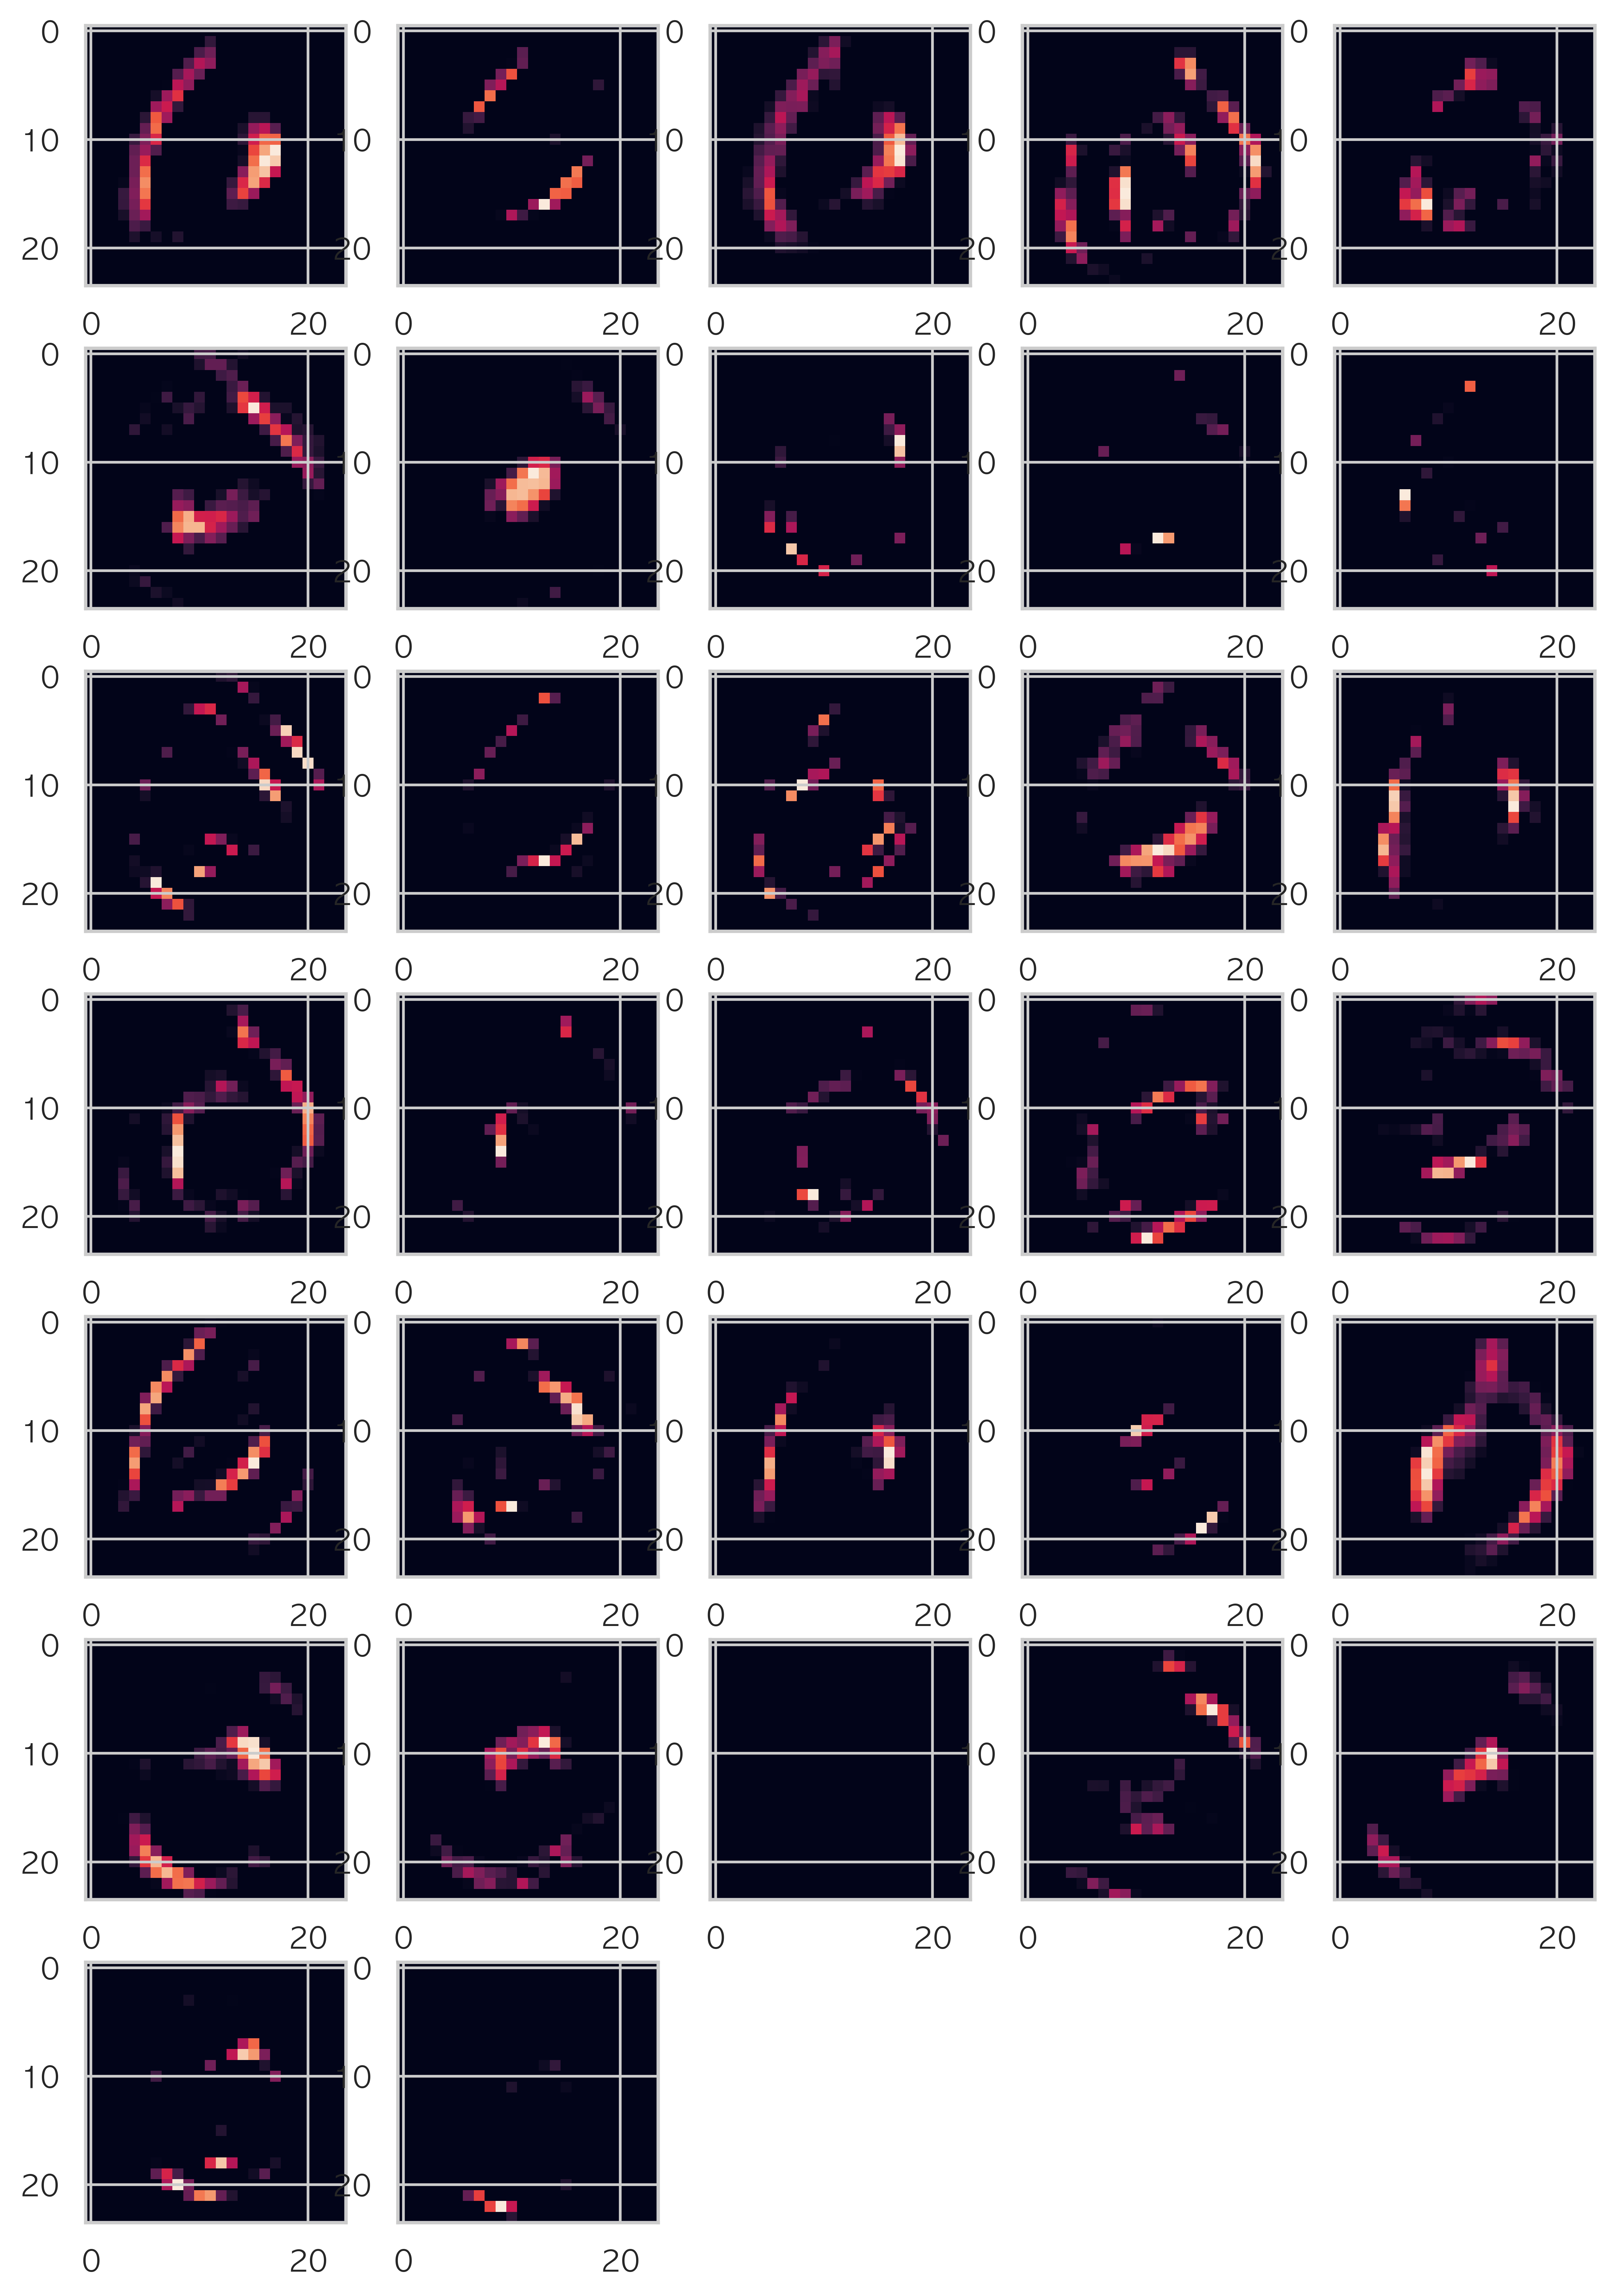

In [74]:
fig = plt.figure(figsize=(10, 15))
for i in range(32):
    fig.add_subplot(7, 5, i+1)
    plt.imshow(activation[3, :, :, i])

feature map 마다 조금씩 다른 숫자 0의 윤곽을 추출하고 있습니다. feature map 마다 차이가 있는 것은 필터가 서로 다른 부분을 학습하기 때문입니다.

이번에는 첫번째 층의 필터를 출력해보겠습니다. 합성곱 필터는 합성곱 layer의 kernel 속성에 저장되어 있습니다. 필터의 차원은 (높이, 너비, 입력 채널, 출력 채널) 입니다. imshow 함수는 그레이스케일 이미지의 경우 (높이, 너비)로, 컬러 이미지일 경우 (높이, 너비, 3)인 배열을 기대합니다. 현재 MNIST 데이터는 그레이스케일 이미지이므로 이 필터의 입력 채널은 한개입니다. 따라서 입력 채널의 인덱스를 0으로 고정하고 마지막 출력 채널을 순회하면서 필터를 그려 보겠습니다.

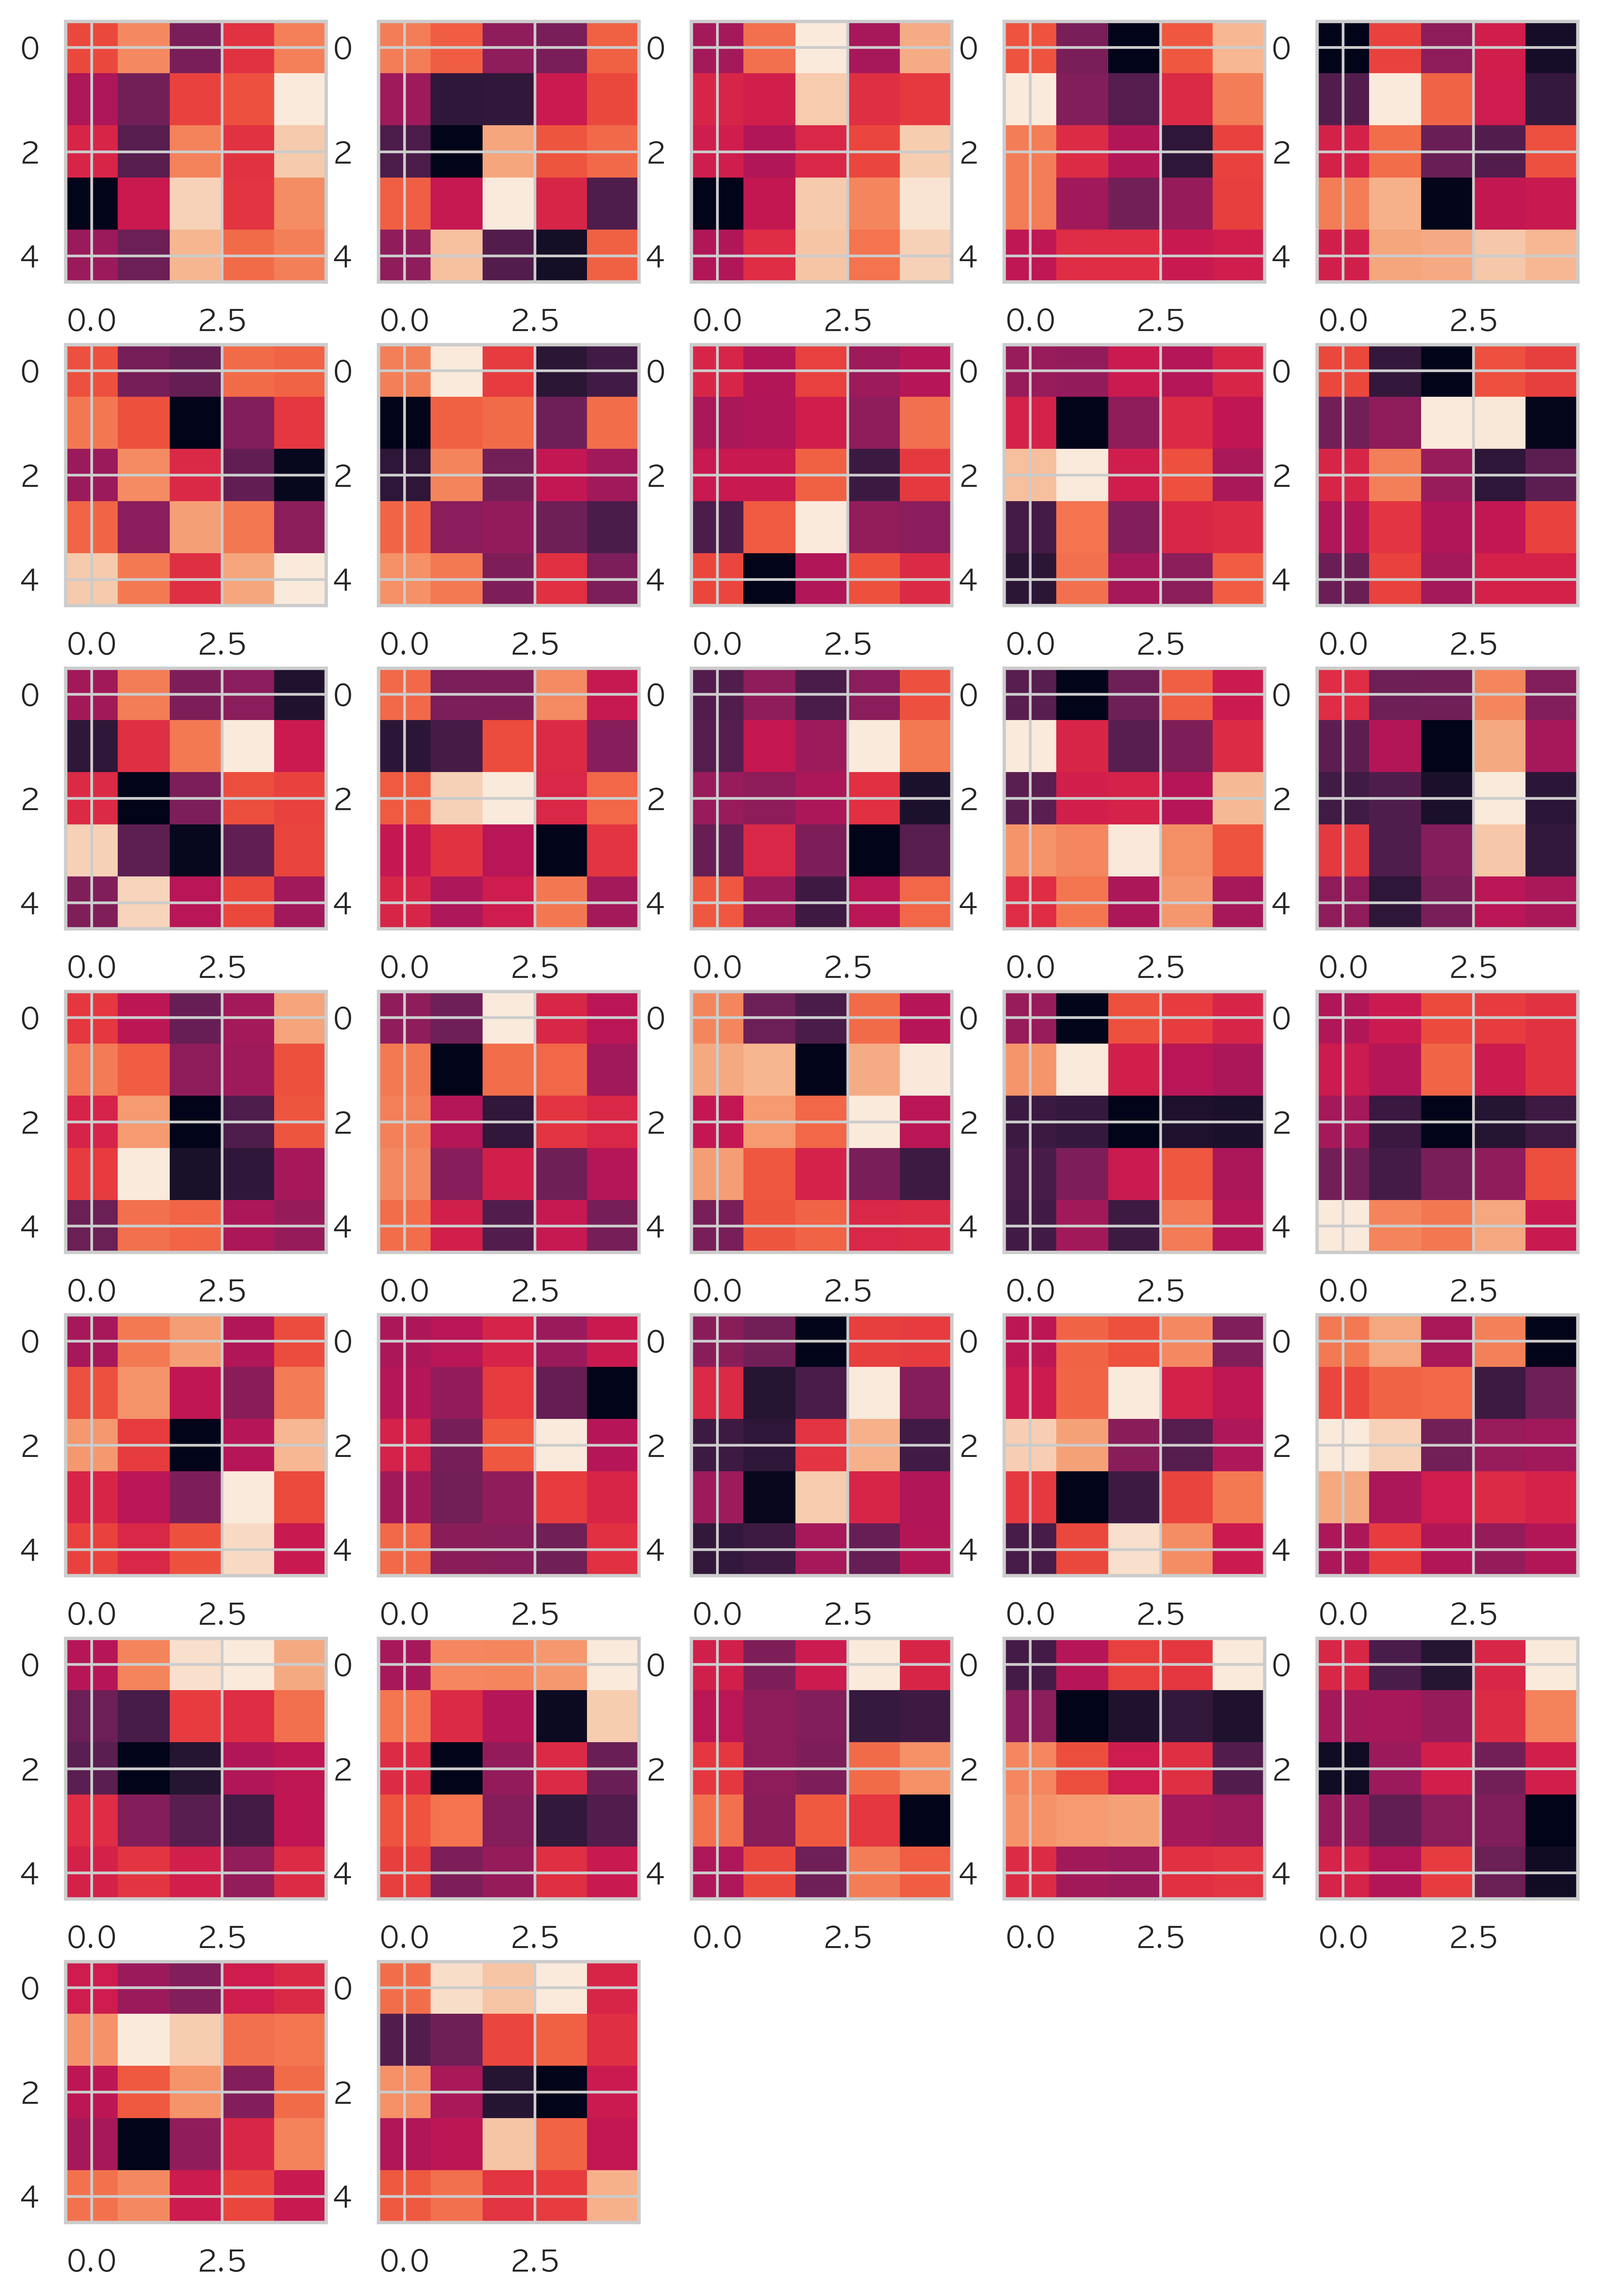

In [76]:
fig = plt.figure(figsize=(10, 15))
for i in range(32):
    fig.add_subplot(7, 5, i+1)
    plt.imshow(first_layer.kernel[:, :, 0, i])

필터의 밝은 부분은 높은 값을 의미합니다. 아홉 번째 필터는 수평 에지를 학습하는 것으로 보입니다. 이 필터를 사용하여 숫자 7에서 추출된 특성은 수평 부분이 잘 나타나 있습니다. 반대로 0은 수평 부분이 많지 않으므로 추출된 특성에 정보가 많이 담겨 있지 않습니다. 합성곱은 활성화 출력과 필터를 분석하면 중요한 통찰을 얻을 수 있는 경우가 많습니다. 층이 깊어질수록 합성곱의 활성화 출력 의미를 이해하기가 어려워집니다.

---